In [1]:
import numpy as np

In [2]:
def make_dist_matrix(X):# n by d의 np.ndarray dataset 가정
    sum_sqr_X = np.sum(np.square(X), axis = 1)# 1 by n의 객체 element 제곱의 합 matrix
    dist_matrix = np.add(np.add(sum_sqr_X, -2*np.dot(X, X.T)).T, sum_sqr_X)# 1 diag(X X^T)^T -2 * X X^T + 1^T diag(X X^T)
    return dist_matrix

In [3]:
def make_p_j_cond_i_mat(dist_matrix, sigma_vec):
    sqrd_sigma_vec = 2. * np.square(sigma_vec.reshape((-1, 1)))
    tmp_matrix = dist_matrix / sqrd_sigma_vec
    exp_matrix = np.exp(tmp_matrix)
    np.fill_diagonal(exp_matrix, 0.) # p_i|i == 0
    exp_matrix = exp_matrix + 1e-10 # avoiding division by 0 
    
    return exp_matrix / exp_matrix.sum(axis=1).reshape([-1, 1])
    
def make_p_ij_mat(p_j_cond_i_mat):
    return (p_j_cond_i_mat + p_j_cond_i_mat.T) / (2. * p_j_cond_i_mat.shape[0])

In [4]:
def make_q_ij_mat(Y):
    dist_matrix = make_dist_matrix(Y)
    invrs_dist_mat = np.power(1. + dist_matrix, -1)
    np.fill_diagonal(invrs_dist_mat, 0.) # q_ii == 0
    
    return invrs_dist_mat / np.sum(invrs_dist_mat), invrs_dist_mat# for gradient

In [5]:
def binary_search(func, target, lower_bound=1e-20, upper_bound=1000., tolerance=1e-10, max_iter=5000):
    for i in range(max_iter):
        guess = (lower_bound+upper_bound)/2
        guess = func(guess) # function will be perplexity calculator from sigma
        if np.abs(guess - target) <= tolerance:
            break
        
        if guess > target:
            upper_bound = guess
        else:
            lower_bound = guess
    
    return guess

def make_perp_vec(dist_matrix, sigma_vec):
    p_j_cond_i_mat = make_p_j_cond_i_mat(dist_matrix, sigma_vec)
    entropy = -np.sum(p_j_cond_i_mat * np.log2(p_j_cond_i_mat), 1)# j에 대해 모두 더함.
    perp_vec = 2 ** entropy# 1 by n perplexity 벡터 
    return perp_vec


def make_sigma_vec(dist_matrix, target_perplexity, make_perp_vec):
    sigma_vec = [] 
    for i in range(dist_matrix.shape[0]):
        func = lambda sigma: \
            make_perp_vec(dist_matrix[i:i+1, :], np.array(sigma)) # 객체 i에 대한 perplexity 계산
        
        correct_sigma = binary_search(func, target_perplexity)
        
        sigma_vec.append(correct_sigma)
    # 1 by n sigma_vec 반환
    return np.array(sigma_vec)

In [6]:
def make_grad_matrix(p_ij_mat, q_ij_mat, Y, invrs_dist_mat):
    pq_diff_mat = p_ij_mat - q_ij_mat
    pq_expanded = np.expand_dims(pq_diff_mat, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    distances_expanded = np.expand_dims(invrs_dist_mat, 2)

    grad_matrix = 4. * (pq_expanded * y_diffs * distances_expanded).sum(1)
    return grad_matrix

In [7]:
def optimization(X, p_ij_mat, max_iter, learning_rate, momentum, target_dim, seed):
    # initialization
    Y = np.random.default_rng(seed=1).normal(0.0, scale = 0.0001, size = [X.shape[0], target_dim])
    Y_t = Y.copy()# momentum
    Y_t_1 = Y.copy()# momentum

    # gradient descent
    for i in range(max_iter):
        # q_ij 구하기
        q_ij_mat, invrs_dist_mat = make_q_ij_mat(Y)
        # gradient 구하기
        grad_matrix = make_grad_matrix(p_ij_mat, q_ij_mat, Y, invrs_dist_mat)

        # solution update
        Y = Y - learning_rate*grad_matrix + momentum*(Y_t - Y_t_1)
        # momentum update
        Y_t_1 = Y_t.copy()
        Y_t = Y.copy()
            
    return Y

In [8]:
def raw_TSNE(X, target_dim, target_perplexity, max_iter, learning_rate, momentum, seed):
    import time
    st = time.time()
    dist_matrix = make_dist_matrix(X)
    print('made dist matrix, ' + str(time.time()-st))
    sigma_vec = make_sigma_vec(dist_matrix, target_perplexity, make_perp_vec)
    print('made sigma vector, ' + str(time.time()-st))
    p_ij_mat = make_p_ij_mat(make_p_j_cond_i_mat(dist_matrix, sigma_vec))
    print('made p_ij_mat, ' + str(time.time()-st))
    Y = optimization(X, p_ij_mat, max_iter, learning_rate, momentum, target_dim, seed)
    print('done, ' + str(time.time()-st))
    
    return Y

In [9]:
import gzip
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    x_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)
with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

In [10]:
X = x_train[0:1000]
label = y_train[0:1000]

In [11]:
tsne_data = raw_TSNE(X, 2, 40, 1000, 200, 0.5, 1013)

made dist matrix, 0.3120419979095459
made sigma vector, 161.8795051574707
made p_ij_mat, 161.89247155189514
done, 245.30310249328613


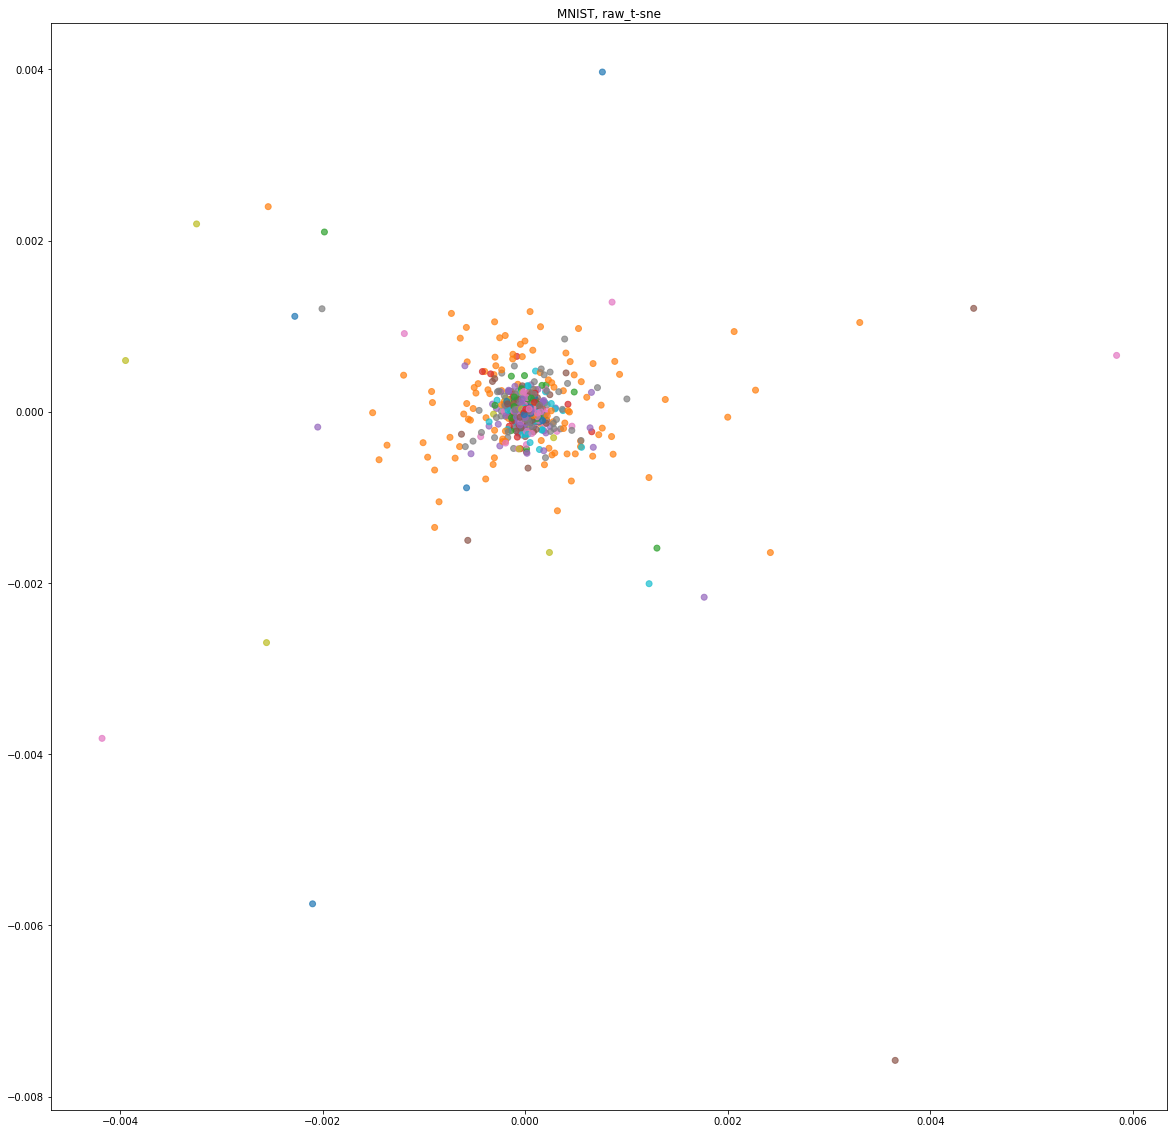

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
tsne_data = pd.DataFrame(tsne_data, columns=['z1', 'z2'])
plt.figure(figsize=(20,20))
plt.title('MNIST, raw_t-sne')
plt.scatter(tsne_data.z1, tsne_data.z2, c=label, alpha=0.7, cmap=plt.cm.tab10)

In [44]:
from sklearn.manifold import TSNE

In [46]:
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)

c:\Users\DAHS\anaconda3\envs\torch_py383\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\DAHS\anaconda3\envs\torch_py383\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [47]:
tsne_data = pd.DataFrame(tsne_data, columns=['z1', 'z2'])

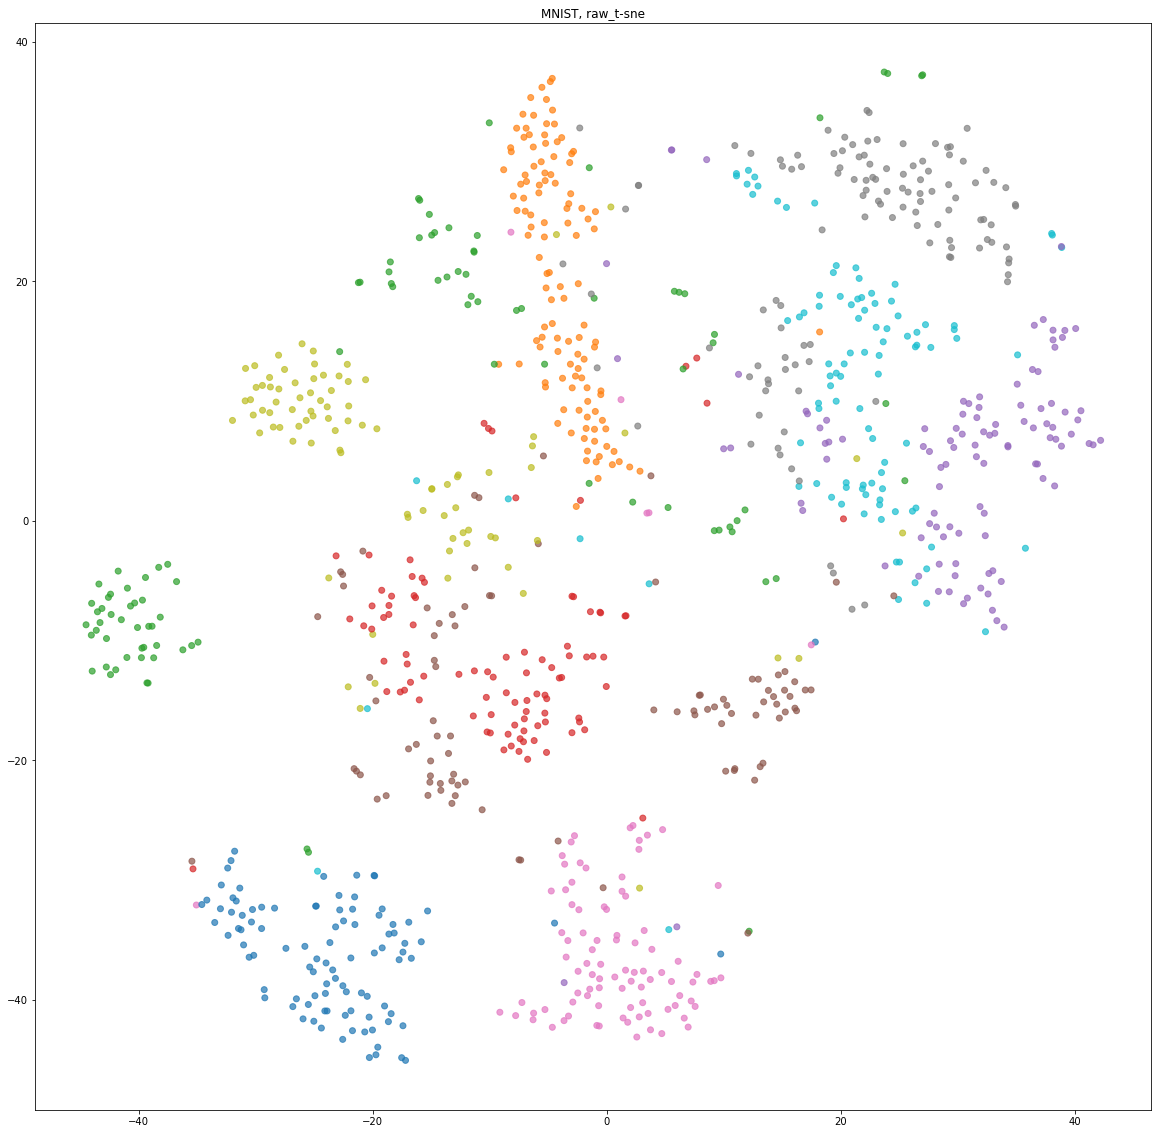

In [48]:
plt.figure(figsize=(20,20))
plt.title('MNIST, sklearn_TSNE')
plt.scatter(tsne_data.z1, tsne_data.z2, c=label, alpha=0.7, cmap=plt.cm.tab10)